# Applied Data Science Capstone - Final Project

##### This notebook holds code for the Applied Data Science Capstone course final project. ( Part of the IBM Data Science Professional Certification )

## Where to Open your Café? - With the Power of Clustering

If you are someone in Stockholm County looking for an excellent location to open a café of your own, this could help you.

How about finding a group of similar neighbourhoods in Stockholm with café as the most common venue type for most neighbourhoods?

Neighbourhoods with well-established café businesses should be good for your new business too, only if there are not too many similar businesses already in the neighbourhood. That is why this solution gives you not one neighbourhood but also find similar neighbourhoods. So if you have too many well established and flourishing café businesses in a neighbourhood, you can go for a similar neighbourhood (based on your other specific requirements), which does not have too many of such joint but does have a potential for profits for a new joint if you open one.

Confusing, was it? Let me explain this to you through steps. With the result in hand, the idea clarifies further.

### Step 1: Import all the required libraries.

Before you start creating models to solve any problem, you need to gather, cleanse and most importantly, explore data. You use many utility functions, classes, and induction models with which you train your data. Let us import all the libraries required for our analysis.

In [3]:
# library for data manipulations and analyses
import pandas as pd

# customise row/column display aspects
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# library for similar manipulation making use of vectors
import numpy as np

# library for HTTP requests
import requests

# library for converting address into latitude and longitude values
from geopy.geocoders import Nominatim

# library for map rendering
!pip install folium
import folium

# scipy's cdist for determining optimal K in K-Means clustering
from scipy.spatial.distance import cdist

# sklearn's KMeans for clustering
from sklearn.cluster import KMeans

# library for colors on maps
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

##### Note: We are using ```Folium``` for map visualisations in this code, but for some reason, ```Folium``` maps are not visible on the GitHub .ipynb files. Nevertheless, we have placed map image files in this repository separately.

### Step 2: Gather data for analysis.

To fetch the venue information from the Foursquare API, we need the geocoordinate information of the Stockholm neighbourhoods. Once we have this information, we can use the latitudes and longitudes to find out the venues in each neighbourhood.

For this data, we use the data present in the ```SE.zip``` file present at ```http://download.geonames.org/export/zip/```. This file consists of the Stockholm County postal code level latitude and longitude information and other information such as district name, municipal name and municipal code.

If you download and unzip the ```SE.zip``` file, you will find that the information we need is present in the text file named ```SE.txt```. This file has been uploaded to the same repository as this notebook (```SE_geo_data.txt```) and is being used directly for convenience. 

In [13]:
# data file URL from GitHub
data_URL = 'https://raw.githubusercontent.com/guptasaumya/coursera-capstone-final/master/SE_geo_data.txt'

# load data into pandas data frame
postal_geocoordinate_data = pd.read_csv(data_URL,
                                        # data file is tab seperated
                                        delimiter="\t",
                                        # file as no column headers
                                        header=None,
                                        # read only the required information
                                        usecols=[2, 3, 9, 10],
                                        names=["Neighbourhood", "County", "Latitude", "Longitude"])

postal_geocoordinate_data.head()

,Neighbourhood,County,Latitude,Longitude
0,Vallentuna,Stockholm,59.5344,18.0776
1,Vallentuna,Stockholm,59.5344,18.0776
2,Brottby,Stockholm,59.5632,18.2403
3,Vallentuna,Stockholm,59.5344,18.0776
4,Vallentuna,Stockholm,59.5344,18.0776


We now have a couple of preprocessing to be done on this data. Since we are dealing in Stockholm County, we remove all the postal codes belonging to counties other than Stockholm. Then we drop the ```County``` column since we have no use left of it.

In [5]:
# remove data of other counties
stockholm_data = postal_geocoordinate_data[postal_geocoordinate_data.County == "Stockholm"].drop("County", axis=1)

# remove column not needed
stockholm_data = stockholm_data[["Neighbourhood", "Latitude", "Longitude"]]

stockholm_data.head()

,Neighbourhood,Latitude,Longitude
0,Vallentuna,59.5344,18.0776
1,Vallentuna,59.5344,18.0776
2,Brottby,59.5632,18.2403
3,Vallentuna,59.5344,18.0776
4,Vallentuna,59.5344,18.0776


We see more than one row for each district because of multiple postal codes within the district. Remember, this is postal codes data. However, we find that the geocoordinate information for all postal codes within a district is the same, indicating a lack of exact data. It is the case with most of the districts but not all. Hence to keep consistency, we remove the duplicates using the ```Neighbourhood``` subset. It results in one postal code per district of Stockholm County with its geocoordinate information.

In [6]:
# remove duplicate rows
stockholm_data.drop_duplicates(subset = ['Neighbourhood'], inplace=True)

Then we make consistent the spelling of the municipalities - Järfälla and Norrtälje in the data.

In [7]:
# correct naming inconsistency
stockholm_data = stockholm_data[~stockholm_data["Neighbourhood"].isin(["Norrtalje", "Järfalla"])]

We end up with geocoordinate data for 121 districts of Stockholm.

In [8]:
# check shape (row represent number of districts in Stockholm county)
stockholm_data.shape

stockholm_data.head()

,Neighbourhood,Latitude,Longitude
0,Vallentuna,59.5344,18.0776
2,Brottby,59.5632,18.2403
43,Ingmarsö,59.4675,18.7494
44,Åkersberga,59.4794,18.2997
45,Ljusterö,59.5275,18.6211


### Step3: Visualise the neighbourhoods/postal codes coordinates on Stockholm city map.

In [192]:
# use geopy library to get latitude and longitude values of city of Stockholm
address = "Stockholm, Sweden"

geolocator = Nominatim(user_agent="stockholm_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Stockholm using latitude and longitude values
map_stockholm = folium.Map(location=[latitude, longitude], zoom_start=8)

# add markers to map
for lat, lng, Neighbourhood in zip(stockholm_data["Latitude"],
                                  stockholm_data["Longitude"],
                                  stockholm_data["Neighbourhood"]):
    label = '{}'.format(Neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stockholm)

map_stockholm

##### Note: For this map result, check out https://github.com/guptasaumya/coursera-capstone/blob/master/map_Torornto.PNG in this repository.

### Define Foursquare API usage credentials and version.

In [193]:
# The code was removed by Watson Studio for sharing.

In [194]:
# define function gets nearby venues for each PostalCode
def getNearbyVenues(names, latitudes, longitudes, radius=500):

    # 'venues_list' stores venues data for all postal codes in list of lists format
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        print(name)

        # create API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # send GET requests and examine results
        response = requests.get(url).json()["response"]['groups'][0]['items']

        # append only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in response])

    # create data frame from list of lists containing PostalCode data
    nearby_venues = pd.DataFrame([item for venue_list in venues_list
                                  for item in venue_list])
    
    # rename columns for uniform column name format
    nearby_venues.columns = ['Neighbourhood',
                             'NeighbourhoodLatitude',
                             'NeighbourhoodLongitude',
                             'Venue',
                             'VenueLatitude',
                             'VenueLongitude',
                             'VenueCategory']

    # return resulting data frame
    return(nearby_venues)

In [195]:
# define function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

In [196]:
# call function to get nearby venues for each neighbourhood
stockholm_venues = getNearbyVenues(stockholm_data['Neighbourhood'],
                                   stockholm_data['Latitude'],
                                   stockholm_data['Longitude'],
                                   # finding neraby venues within 500 meters radius
                                   500)

stockholm_venues.head()

Vallentuna
Brottby
Ingmarsö
Åkersberga
Ljusterö
Österskär
Gällnöby
Skälvik
Nämdö
Stavsnäs
Runmarö
Sandhamn
Djurhamn
Stavsudda
Möja
Gustavsberg
Ingarö
Värmdö
Järfälla
Ekerö
Drottningholm
Munsö
Adelsö
Stenhamra
Färentuna
Svartsjö
Skå
Färentuna
Skärholmen
Huddinge
Kungens Kurva
Segeltorp
Kungens Kurva
Skogås
Trångsund
Vårby
Norsborg
Tullinge
Tumba
Grödinge
Uttran
Grödinge
Rönninge
Dalarö
Ornö
Utö
Hårsfjärden
Haninge
Handen
Vega
Västerhaninge
Tungelsta
Muskö
Tyresö
Nykvarn
Täby
Danderyd
Enebyberg
Djursholm
Stocksund
Stockholm
Årsta
Enskede Gård
Johanneshov
Enskededalen
Stockholm-Globen
Stockholm-Globen
Enskede
Farsta
Bandhagen
Älvsjö
Hägersten
Skarpnäck
Bagarmossen
Sköndal
Bagarmossen
Bromma
Vällingby
Spånga
Kista
Hässelby
Mölnbo
Enhörna
Södertälje
Järna
Hölö
Nacka
Nacka Strand
Saltsjö-Duvnäs
Nacka Strand
Nacka Strand
Nacka Strand
Saltsjö-Boo
Saltsjöbaden
Älta
Sundbyberg
Solna
Tomteboda
Tomteboda
Lidingö
Vaxholm
Bergshamra
Gräddö
Blidö
Yxlan
Furusund
Vätö
Väddö
Arholma
Björkö
Barnens Ö
Gri

,Neighbourhood,NeighbourhoodLatitude,NeighbourhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Vallentuna,59.5344,18.0776,Vallentuna Stenugnsbageri,59.534369,18.077338,Bakery
1,Vallentuna,59.5344,18.0776,Gym & Sim,59.533476,18.084472,Gym
2,Vallentuna,59.5344,18.0776,Lidl Vallentuna,59.532625,18.083467,Supermarket
3,Vallentuna,59.5344,18.0776,Vallentuna (L),59.533849,18.079585,Light Rail Station
4,Vallentuna,59.5344,18.0776,Vallentuna Centrum,59.534321,18.078444,Plaza


<AxesSubplot:>

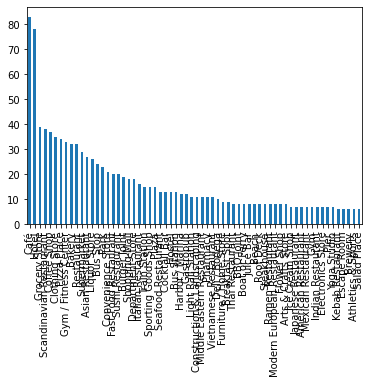

In [212]:
most_common_venues = stockholm_venues['VenueCategory'].value_counts().loc[lambda x: x>5].reset_index()['index']

stockholm_venues = stockholm_venues[stockholm_venues['VenueCategory'].isin(most_common_venues)]

stockholm_venues.VenueCategory.value_counts().plot(kind="bar")

#### Pre-process the data before clustering analysis.

In [198]:
# one-hot encoding
stockholm_onehot = pd.get_dummies(stockholm_venues[['VenueCategory']],
                                prefix="",
                                prefix_sep="")

# add 'Neighbourhood' column to this data frame
stockholm_onehot['Neighbourhood'] = stockholm_venues['Neighbourhood'] 

# move 'Neighbourhood' column to first position
fixed_columns = [stockholm_onehot.columns[-1]] + list(stockholm_onehot.columns[:-1])
stockholm_onehot = stockholm_onehot[fixed_columns]

# group rows by neighbourhood taking mean of frequency of occurrence of each category
stockholm_grouped = stockholm_onehot.groupby('Neighbourhood').mean().reset_index()

stockholm_grouped.head()

,Neighbourhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Beach,Boat or Ferry,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Café,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Deli / Bodega,Department Store,Electronics Store,Escape Room,Fast Food Restaurant,Flower Shop,Furniture / Home Store,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Park,Pharmacy,Pier,Pizza Place,Plaza,Ramen Restaurant,Restaurant,Roof Deck,Salad Place,Scandinavian Restaurant,Seafood Restaurant,Shopping Mall,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Train Station,Vietnamese Restaurant,Yoga Studio
0,Arholma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.500000,0.000000,0.000000,0.5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,Bagarmossen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.142857,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.142857,0.000000,0.142857,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.000000,0.0,0.0
2,Bandhagen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.000000,0.076923,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.076923,0.153846,0.0,0.0,0.076923,0.076923,0.000000,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.076923,0.0,0.0
3,Blidö,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,Bro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.500000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


#### Get top 10 most common venue categories for each postal code/neighbourhood for future cluster examinations.

In [199]:
# we will look into top 10 most common venue categories
num_top_venues = 10

# define positions indicator suffixes
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create new data frame structure
stockholm_venues_sorted = pd.DataFrame(columns=columns)

# add neighbourhood data
stockholm_venues_sorted['Neighbourhood'] = stockholm_grouped['Neighbourhood']

# add top 10 most common venue categories for these neighbourhoods
for ind in np.arange(stockholm_grouped.shape[0]):
    stockholm_venues_sorted.iloc[ind, 1:] = return_most_common_venues(stockholm_grouped.iloc[ind, :],
                                                                          num_top_venues)

stockholm_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arholma,Harbor / Marina,Grocery Store,American Restaurant,Pizza Place,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Light Rail Station,Liquor Store
1,Bagarmossen,Plaza,Bus Stop,Gym / Fitness Center,Supermarket,Grocery Store,Pizza Place,Bus Station,Pier,Pharmacy,Park
2,Bandhagen,Flower Shop,Light Rail Station,Hotel,Gym,Fast Food Restaurant,Café,Bus Station,Pizza Place,Grocery Store,Train Station
3,Blidö,Bakery,American Restaurant,Plaza,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant
4,Bro,Fast Food Restaurant,Convenience Store,American Restaurant,Pizza Place,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Light Rail Station,Liquor Store


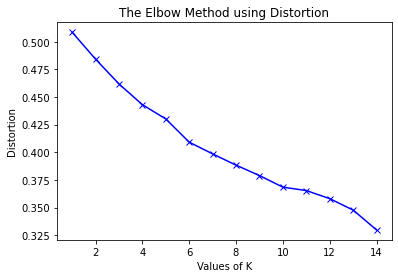

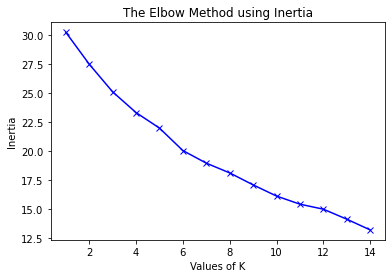

In [200]:
# find optimal k checking both distortions and inertias

# define clustering data (data on basis of which clustering is performed)
stockholm_grouped_clustering = stockholm_grouped.drop('Neighbourhood', 1)

# we will check elbow plots for distortions and inertias
distortions = []
inertias = []

# check for K ranging from 1 to 10
K = range(1, 15)

for k in K:
    # define KMeans object
    kmeans_model = KMeans(n_clusters = k, random_state=0)
    
    # fit clustering data
    kmeans_model.fit(stockholm_grouped_clustering)
 
    # calculate distortion measure
    distortions.append(sum(np.min(cdist(stockholm_grouped_clustering, kmeans_model.cluster_centers_,
                                        'euclidean'), axis = 1)) / stockholm_grouped_clustering.shape[0])
    # calculate inertia measure
    inertias.append(kmeans_model.inertia_)
    
# plot distortions elbow plot (with different Ks)
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

# plot inertias elbow plot (with different Ks)
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

#### 5 number of clusters seems to be the elbow and hence a good K-value.

In [201]:
# fit kmeans model with 5 clusters - optimal value of k
kclusters = 11

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(stockholm_grouped_clustering)

# check cluster labels generated for each row in data frame
kmeans.labels_

array([ 9,  7,  0,  0,  5,  9,  1,  0,  0,  0,  0,  8,  0,  0,  1,  7,  9,
        0,  1,  5,  3,  0,  9,  9,  9,  0,  0,  0,  0,  7,  9,  0,  0,  7,
        0,  0,  9,  0,  7,  1,  0,  0,  8,  9,  8,  9,  4,  9,  2,  9,  6,
        9,  0,  0,  7,  8,  7, 10,  9,  0,  4,  8,  0,  0,  9,  7,  0,  6,
        0,  0,  3,  0,  0,  8,  0,  9,  4,  8,  0,  0,  4,  0,  7,  0,  2,
        0,  7,  1,  2,  0,  0,  9,  9,  0], dtype=int32)

In [202]:
# combine clustering information with other data for cluster examination
stockholm_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

stockholm_merged = stockholm_data

# merge stockholm_grouped with stockholm_data to add latitude/longitude for each neighbourhood
stockholm_merged = stockholm_merged.join(stockholm_venues_sorted.set_index('Neighbourhood'),
                                     on='Neighbourhood', how='right')

stockholm_merged.head()

,Neighbourhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2685,Arholma,59.8500,19.1000,9,Harbor / Marina,Grocery Store,American Restaurant,Pizza Place,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Light Rail Station,Liquor Store
1799,Bagarmossen,59.2556,18.1167,7,Plaza,Bus Stop,Gym / Fitness Center,Supermarket,Grocery Store,Pizza Place,Bus Station,Pier,Pharmacy,Park
1816,Bagarmossen,59.2600,18.1167,7,Plaza,Bus Stop,Gym / Fitness Center,Supermarket,Grocery Store,Pizza Place,Bus Station,Pier,Pharmacy,Park
1651,Bandhagen,59.2968,18.0313,0,Flower Shop,Light Rail Station,Hotel,Gym,Fast Food Restaurant,Café,Bus Station,Pizza Place,Grocery Store,Train Station
2680,Blidö,59.6150,18.8917,0,Bakery,American Restaurant,Plaza,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant


In [204]:
# look at number of neighbourhoods per cluster
stockholm_merged.ClusterLabels.value_counts()

0     48
9     21
7     11
8      7
1      5
4      4
2      3
3      3
5      2
6      2
10     1
Name: ClusterLabels, dtype: int64

### Display clustered Stockholm city neighbourhoods on map.

In [205]:
# create map of stockholm using latitude and longitude value
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
markers_colors = []
for lat, lon, poi, cluster in zip(stockholm_merged['Latitude'],
                                  stockholm_merged['Longitude'],
                                  stockholm_merged['Neighbourhood'],
                                  stockholm_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster),
                         parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

    # view clusters at end
map_clusters

##### Note: For this map result, check out https://github.com/guptasaumya/coursera-capstone/blob/master/map_clustered_neighbourhoods_Stockholm.PNG in this repository.

### Examine clusters.

In [206]:
# Examine cluster 0
cluster_0 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 0,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_0['1st Most Common Venue'].value_counts()

Hotel                         13
Pier                           4
Clothing Store                 3
Harbor / Marina                2
Ice Cream Shop                 2
Restaurant                     2
Flower Shop                    2
Plaza                          2
Café                           2
Beach                          2
Grocery Store                  2
Coffee Shop                    2
Liquor Store                   1
Furniture / Home Store         1
Convenience Store              1
Hostel                         1
Pizza Place                    1
Bakery                         1
Indian Restaurant              1
Fast Food Restaurant           1
Gym / Fitness Center           1
Construction & Landscaping     1
Name: 1st Most Common Venue, dtype: int64

In [207]:
# Examine cluster 1
cluster_1 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 1,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_1['1st Most Common Venue'].value_counts()

Pizza Place      4
Grocery Store    1
Name: 1st Most Common Venue, dtype: int64

In [208]:
# Examine cluster 2
cluster_2 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 2,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_2['1st Most Common Venue'].value_counts()

Bus Stop    3
Name: 1st Most Common Venue, dtype: int64

In [209]:
# Examine cluster 3
cluster_3 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 3,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_3['1st Most Common Venue'].value_counts()

Coffee Shop    3
Name: 1st Most Common Venue, dtype: int64

In [210]:
# Examine cluster 4
cluster_4 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 4,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_4['1st Most Common Venue'].value_counts()

Café             4
Restaurant       1
Park             1
Boat or Ferry    1
Name: 1st Most Common Venue, dtype: int64

In [1]:
# Examine cluster 5
cluster_5 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 5,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_5['1st Most Common Venue'].value_counts()

NameError: name 'stockholm_merged' is not defined

In [ ]:
# Examine cluster 6
cluster_6 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 6,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_6['1st Most Common Venue'].value_counts()

In [ ]:
# Examine cluster 7
cluster_7 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 7,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_7['1st Most Common Venue'].value_counts()

In [ ]:
# Examine cluster 8
cluster_8 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 8,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_8['1st Most Common Venue'].value_counts()

In [ ]:
# Examine cluster 9
cluster_9 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 9,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_9['1st Most Common Venue'].value_counts()

In [ ]:
# Examine cluster 10
cluster_10 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 10,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_10['1st Most Common Venue'].value_counts()

In [211]:
stockholm_merged[stockholm_merged['ClusterLabels'] == 8]

,Neighbourhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
252,Drottningholm,59.3251,17.8878,8,Boat or Ferry,Café,Convenience Store,American Restaurant,Modern European Restaurant,Pizza Place,Pier,Pharmacy,Park,Mexican Restaurant
2690,Norrtälje,59.7580,18.7050,8,Café,Hotel,Burger Joint,Liquor Store,Boat or Ferry,Pizza Place,Pier,Pharmacy,Park,Modern European Restaurant
2795,Nynäshamn,58.9034,17.9479,8,Café,Boat or Ferry,Seafood Restaurant,Scandinavian Restaurant,Hotel,Harbor / Marina,Liquor Store,Fast Food Restaurant,Pharmacy,Pier
3313,Sigtuna,59.6173,17.7236,8,Café,Scandinavian Restaurant,Hotel,Gym / Fitness Center,Grocery Store,Convenience Store,Plaza,Steakhouse,Pharmacy,Japanese Restaurant
1801,Sköndal,59.2500,18.1167,8,Café,Park,Bus Station,American Restaurant,Middle Eastern Restaurant,Pier,Pharmacy,Modern European Restaurant,Mexican Restaurant,Plaza
356,Trångsund,59.2333,18.1333,8,Park,Café,American Restaurant,Plaza,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Light Rail Station,Liquor Store
585,Tyresö,59.2333,18.3000,8,Restaurant,Café,Bus Station,Middle Eastern Restaurant,Pier,Pharmacy,Park,Modern European Restaurant,Mexican Restaurant,Plaza


### End of Analysis